```
deepfake_recognition Final Project
CS 555 AI
Spring 2025

Group 2
Members: Simardeep Khinda, Peter Nguyen, Jessica Sammons, Catharine Tew

This code was adapted with the help of Shradhdha Bhalodia's code at
https://www.kaggle.com/code/praveenraj001/deep-fake-image-classification-using-cnn
The dataset used in this code is provided on the Kaggle website:
https://www.kaggle.com/datasets/saurabhbagchi/deepfake-image-detection/data


In this project we use AI model to classify images as fake or real. This code file loads the dataset, trains, create a trained model file .keras, then does prediction on individual images.```

In [ ]:
# Import Modules
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Mouting a drive if using Google Colab, etc. "work_dir" in the next Code cell will need to be updated accordingly.
# E.g.)
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [51]:
# Load Data
def load_data(dataset_path):
    """
    Load image paths and categories from the dataset, display sample images.
    Args:
        dataset_path (str): Path to the dataset folder containing category subfolders.
    Returns:
        tuple: (img_paths, categories) where img_paths is a list of image file paths
               and categories is a list of category names.
    """
    # List categories (fake & real)
    categories = [category for category in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, category))]

    # Collect all image paths and sample images for display
    img_paths = []
    sample_images = []
    for category in categories:
        class_path = os.path.join(dataset_path, category)
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for img in images:
            img_path = os.path.join(class_path, img)
            img_paths.append((img_path, category))  # Store path and category
            if len(sample_images) < 10 and len([s for s, c in sample_images if c == category]) < 5:
                sample_images.append((img_path, category))  # Limit to 5 per category

    # Display sample images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, (img_path, label) in enumerate(sample_images):
        img = load_img(img_path)
        ax = axes[i // 5, i % 5]
        ax.imshow(img)
        ax.set_title(label)
        ax.axis("off")
    plt.show()

    return img_paths, categories

def CNN_learning(img_paths, categories):
    """
    Train a CNN model using the provided image paths and categories.
    Args:
        img_paths (list): List of tuples (image_path, category).
        categories (list): List of category names.
    Returns:
        model: Trained Keras model.
    """
    IMG_SIZE = (128, 128)
    BATCH_SIZE = 32

    # Function to load and preprocess images
    def load_and_preprocess_image(img_path):
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        return img_array

    # Load all images and labels
    image_data = []
    labels = []
    label_map = {category: idx for idx, category in enumerate(categories)}
    for img_path, category in img_paths:
        image_data.append(load_and_preprocess_image(img_path))
        labels.append(label_map[category])

    # Convert to numpy arrays
    image_data = np.array(image_data)
    labels = np.array(labels)

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

    # Define augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    # Generate augmented images
    augmented_images = datagen.flow(X_train[:5], batch_size=5)
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i, img in enumerate(augmented_images):
        if i >= 1:
            break
        for j in range(5):
            axes[j].imshow(img[j])
            axes[j].axis("off")
    plt.show()

    # Build CNN Model
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(len(categories), activation="softmax")
    ])

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()

    history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        validation_data=(X_val, y_val),
                        epochs=10,
                        verbose=1)

    # Plot Accuracy and Loss Curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Save the trained model
    model.save('/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/model.keras')

    return model

def raw_predict(model, test_img_path):
    """
    Predict the class of a single test image.
    Args:
        model: Trained Keras model.
        test_img_path (str): Path to the test image.
    """
    input_img = load_img(test_img_path, target_size=(128, 128))
    input_array = img_to_array(input_img)
    input_array = np.expand_dims(input_array, axis=0)
    input_array = input_array / 255.0

    predictions = model.predict(input_array)
    print("Raw predictions (probabilities for each class):", predictions)

    predicted_class_idx = np.argmax(predictions, axis=-1)
    print(f"Predicted class index: {predicted_class_idx}")

    class_labels = ['fake', 'real']
    # Check if predicted_class_idx[0] is within the valid range
    if 0 <= predicted_class_idx[0] < len(class_labels):
        predicted_class_name = class_labels[predicted_class_idx[0]]
        print(f"Predicted class name: {predicted_class_name}")
    else:
        print(f"Warning: Predicted class index {predicted_class_idx[0]} is out of range.")
        print(f"Valid class indices are: 0 to {len(class_labels) - 1}")

def batch_predict(model, image_paths, class_labels=None):
    """
    Predict the classes of multiple test images.
    Args:
        model: Trained Keras model.
        image_paths (list): List of paths to test images.
        class_labels (list): Optional list of class names. Defaults to ['fake', 'real'].
    """
    if class_labels is None:
        class_labels = ['fake', 'real']

    IMG_SIZE = (128, 128)
    image_data = []

    for path in image_paths:
        try:
            img = load_img(path, target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            image_data.append(img_array)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            continue

    if not image_data:
        print("No valid images to predict.")
        return

    image_data = np.array(image_data)
    predictions = model.predict(image_data)

    for i, probs in enumerate(predictions):
        predicted_class_idx = np.argmax(probs)
        predicted_class_name = class_labels[predicted_class_idx]
        print(f"Image: {image_paths[i]}")
        print(f"  Probabilities: {probs}")
        print(f"  Predicted class index: {predicted_class_idx}")
        print(f"  Predicted class name: {predicted_class_name}")
        print("-" * 50)


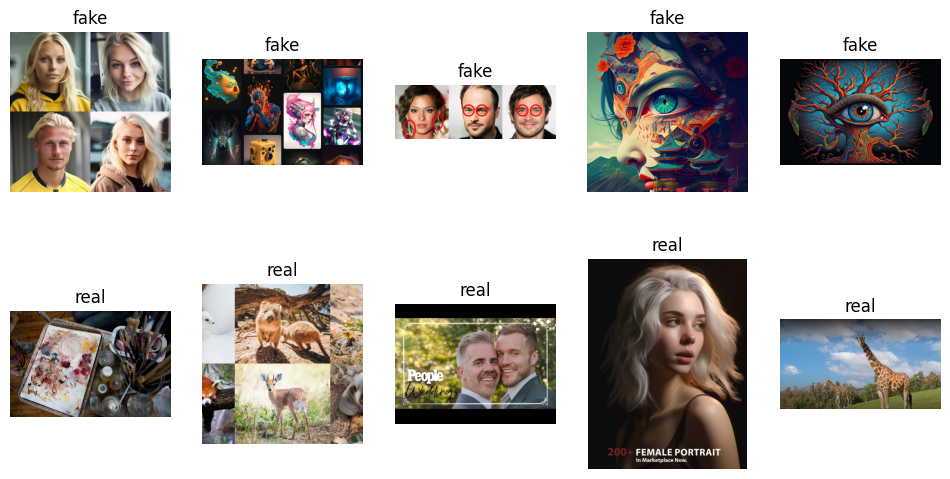

Found 479 images in 2 categories.
model.keras	    test-20250112T065939Z-001
Sample_fake_images  train-20250112T065955Z-001


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train shape: (344, 128, 128, 3), Validation shape: (39, 128, 128, 3), Test shape: (96, 128, 128, 3)


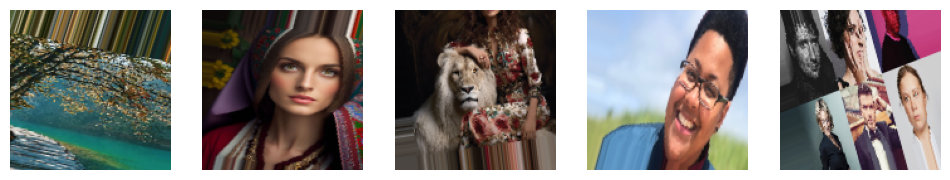

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5647 - loss: 0.8489 - val_accuracy: 0.6410 - val_loss: 0.6661
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6869 - loss: 0.6239 - val_accuracy: 0.6410 - val_loss: 0.6863
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6950 - loss: 0.5982 - val_accuracy: 0.6410 - val_loss: 0.6264
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 936ms/step - accuracy: 0.7228 - loss: 0.5778 - val_accuracy: 0.5641 - val_loss: 0.6489
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6379 - loss: 0.5899 - val_accuracy: 0.6154 - val_loss: 0.6266
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7147 - loss: 0.5947 - val_accuracy: 0.6154 - val_loss: 0.6124
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7128 - loss: 0.5660 - val_accuracy: 0.6410 - val_loss: 0.6084
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7540 - loss: 0.5409 - val_accuracy: 0.6410 - val_lo

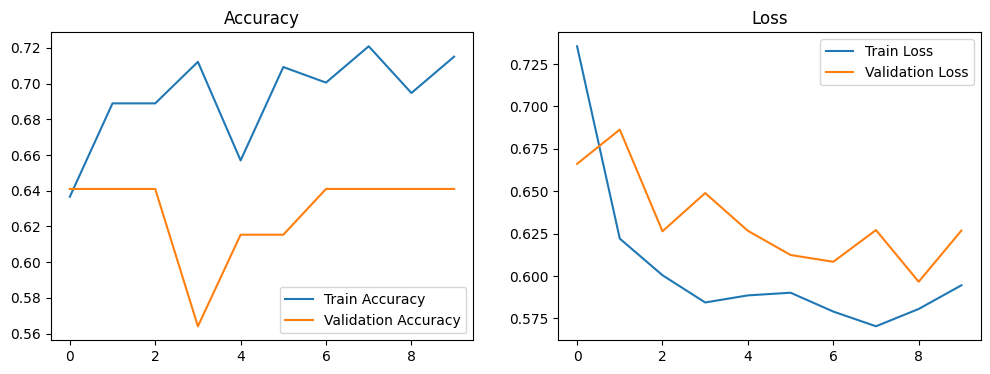

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step - accuracy: 0.6393 - loss: 0.6355
Test Accuracy: 0.6458


In [ ]:
# Main execution

# Set dataset path (update based on environment)
dataset_path = "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/train-20250112T065955Z-001/train"

img_paths, categories = load_data(dataset_path)
print(f"Found {len(img_paths)} images in {len(categories)} categories.")
!ls "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection"


model = CNN_learning(img_paths, categories)

# Example test image path (update to a valid image from your dataset)
test_img_path = "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/fake/123.jpg"

In [ ]:
raw_predict(model, test_img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Raw predictions (probabilities for each class): [[0.29776314 0.7022369 ]]
Predicted class index: [1]
Predicted class name: real


In [56]:
image_list = [
    "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/fake/0.jpg",
    "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/fake/1.jpg",
    "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/fake/2.jpg",
    "/content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/fake/3.jpg"
]

batch_predict(model, image_list)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Image: /content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/fake/0.jpg
  Probabilities: [0.21030979 0.7896902 ]
  Predicted class index: 1
  Predicted class name: real
--------------------------------------------------
Image: /content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/fake/1.jpg
  Probabilities: [0.24814124 0.7518587 ]
  Predicted class index: 1
  Predicted class name: real
--------------------------------------------------
Image: /content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/fake/2.jpg
  Probabilities: [0.3216181 0.6783819]
  Predicted class index: 1
  Predicted class name: real
--------------------------------------------------
Image: /content/drive/My Drive/Colab Notebooks/deepfake-image-detection/test-20250112T065939Z-001/test/fake/3.jpg
  Probabilities: [0.08311238 0.9168876 ]
  Predicted class inde